# Analisi dei Risultati: Test di Robustezza su Modello LNN

Questa sezione descrive la metodologia di testing avversario e l'interpretazione quantitativa delle performance del modello **LNN Autoencoder** nel rilevamento di anomalie marittime (AIS).

### 1. Metodologia del Test
Il codice non si limita a validare il modello su un dataset statico, ma implementa una **pipeline di iniezione attiva** degli attacchi per valutare la sensibilità della rete a diverse tipologie di manipolazione cinematica.

* **Generazione del Dataset:** Vengono caricati circa 15.000 batch di dati reali "puliti" (Normal).
* **Iniezione degli Attacchi:** Il dataset viene duplicato e manipolato sinteticamente per creare 4 scenari di minaccia distinti:
    1.  **Speed Spoofing:** Aggiunta di rumore gaussiano alla velocità (SOG).
    2.  **Teleport:** Spostamento istantaneo delle coordinate negli ultimi 5 step temporali.
    3.  **Ghost Ship:** Inversione di rotta (COG) combinata a jitter, simulando una manovra incoerente.
    4.  **Silent Drift:** Deriva posizionale progressiva e lineare (spoofing lento).
* **Criterio di Rilevamento:** Si utilizza l'Errore Medio Assoluto (MAE) di ricostruzione. La soglia di allarme è dinamica, calcolata statisticamente sulla distribuzione dell'errore dei dati normali nel test set:
    $$Threshold = \mu_{norm} + 3\sigma_{norm}$$

### 2. Analisi Quantitativa dei Risultati

L'esecuzione ha processato un totale di **960.000 campioni**, ottenendo una soglia operativa di **0.023947**.

#### Metriche Globali
Il modello dimostra un'elevata capacità di generalizzazione con performance complessive molto solide:
* **Accuracy:** 97%
* **F1-Score (Classe Attack):** 0.98
* **Recall (Detection Rate):** 0.97

#### Dettaglio per Scenario di Attacco
I tassi di rilevamento (Detection Rate) evidenziano come la LNN risponda alle diverse dinamiche fisiche:

| Scenario | Rilevati / Totali | Rate | Analisi Tecnica |
| :--- | :--- | :--- | :--- |
| **Speed Spoofing** | 192k / 192k | **100.00%** | L'anomalia sulla velocità rompe drasticamente la continuità temporale appresa dalla LNN. Rilevamento immediato. |
| **Teleport** | 192k / 192k | **100.00%** | Il salto di coordinate genera un errore di ricostruzione massiccio (spike) nel layer di output. |
| **Silent Drift** | 192k / 192k | **100.00%** | Nonostante la deriva sia lenta, la LNN (grazie alla memoria delle ODE) rileva l'incoerenza tra la cinematica attesa e la posizione effettiva. |
| **Ghost Ship** | 166k / 192k | **86.75%** | **Punto Critico.** L'attacco agisce principalmente sul COG (rotta). Poiché la nave si muove comunque in modo "fisicamente possibile" (anche se errato), l'errore di ricostruzione è inferiore rispetto agli altri attacchi, portando a un 13% di Falsi Negativi che cadono sotto la soglia. |

#### Falsi Positivi (FP)
Il tasso di **Falsi Positivi è dell'1.57%** (3011 campioni su 192.000 normali). Questo indica che la soglia ($3\sigma$) è ben calibrata, ma esiste una piccola frazione di traffico legittimo con manovre complesse che il modello fatica a ricostruire perfettamente.

### 3. Conclusioni Operative
Il grafico della distribuzione degli errori (istogramma finale) conferma visivamente i dati tabellari:
* Le distribuzioni di *Speed*, *Teleport* e *Drift* sono nettamente separate dalla zona normale (errore alto).
* La distribuzione *Ghost Ship* presenta una parziale sovrapposizione con la coda destra della distribuzione *Normal*, spiegando il calo di performance specifico per questa classe.

Il sistema è **estremamente robusto** contro manipolazioni posizionali e di velocità, mentre mostra margini di miglioramento sulla discriminazione di anomalie pure di rotta (COG).

Configurazione Iniziale Completata.
Funzioni definite
Funzioni di attacco definite.
Costruzione Modello LNN


I0000 00:00:1764852343.085033    4918 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Modello Caricato e Pesi Ripristinati.
Caricamento 15000 batch di dati puliti...
Dati caricati: (960000, 30, 4)
Iniezione Attacchi
Esecuzione Predizioni LNN:
15000/15000 [==============================] - 321s 21ms/step

Soglia Calcolata (Mean+3Std su Normali): 0.023947

REPORT LNN-ONLY (N=960000)
              precision    recall  f1-score   support

      Normal       0.88      0.98      0.93    192000
      Attack       1.00      0.97      0.98    768000

    accuracy                           0.97    960000
   macro avg       0.94      0.98      0.96    960000
weighted avg       0.97      0.97      0.97    960000

--------------------------------------------------
SCENARIO             | RILEVATI            | RATE      
--------------------------------------------------
1. Speed Spoofing    | 192000   / 192000   | 100.00%
2. Teleport          | 192000   / 192000   | 100.00%
3. Ghost Ship        | 166552   / 192000   | 86.75%
4. Silent Drift      | 192000   / 192000   | 100.00%
------

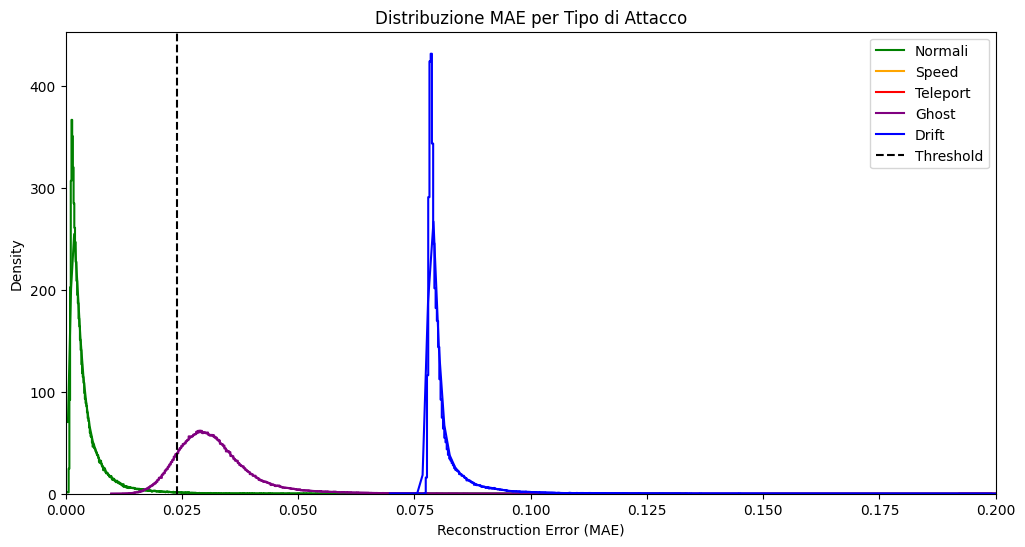

In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import gc

# Import LNN
from ncps.tf import CfC
from ncps.wirings import AutoNCP
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, RepeatVector
from tensorflow.keras import mixed_precision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Configurazione GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError: pass

# Configurazione
WINDOW_SIZE = 30
BATCH_SIZE = 64 # O quello che preferisci per il test
COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL' # Assicurati che il path sia corretto
SCALER_PATH = 'scaler.joblib'
WEIGHTS_PATH = 'lnn_autoencoder_best.weights.h5'

# Parametri Modello LNN
RECURRENT_UNITS = 128
BOTTLENECK_SIZE = 64

print("Configurazione Iniziale Completata.")

# Funzioni

def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")
    

# Definizione Attacchi

def inject_attacks(X_clean):
    n_samples = len(X_clean)
    n_cats = 5 # 1 Normale + 4 Attacchi
    split_size = n_samples // n_cats
    
    X_mixed = X_clean.copy()
    y_true = np.zeros(n_samples)
    attack_type = np.zeros(n_samples) # 0:Normal, 1:Speed, 2:Teleport, 3:Ghost, 4:Drift

    # Indici
    idx_norm = range(0, split_size)
    idx_speed = range(split_size, 2*split_size)
    idx_tele = range(2*split_size, 3*split_size)
    idx_ghost = range(3*split_size, 4*split_size)
    idx_drift = range(4*split_size, n_samples) # Arriva fino alla fine

    # 1. Speed Spoofing (Rumore forte su SOG)
    # Aggiungiamo rumore significativo alla velocità
    noise_speed = np.random.normal(5.0, 2.0, X_mixed[idx_speed, :, 2].shape) 
    X_mixed[idx_speed, :, 2] += noise_speed
    y_true[idx_speed] = 1
    attack_type[idx_speed] = 1

    # 2. Teleport (Salto di posizione finale)
    # Salto improvviso negli ultimi 5 step
    X_mixed[idx_tele, -5:, 0] += 0.5 
    X_mixed[idx_tele, -5:, 1] += 0.5
    y_true[idx_tele] = 1
    attack_type[idx_tele] = 2

    # 3. Ghost Ship (Inversione Rotta + Jitter)
    # Inversione COG (180 gradi circa) + rumore
    X_mixed[idx_ghost, :, 3] = (X_mixed[idx_ghost, :, 3] + 0.5) % 1.0 
    X_mixed[idx_ghost, :, 3] += np.random.normal(0, 0.2, X_mixed[idx_ghost, :, 3].shape)
    y_true[idx_ghost] = 1
    attack_type[idx_ghost] = 3

    # 4. Silent Drift (Deriva progressiva)
    # Drift lineare da 0 a 0.01 (più sottile per testare la sensibilità)
    drift_rate = 0.01
    steps = np.arange(WINDOW_SIZE)
    drift_vector = steps * drift_rate
    X_mixed[idx_drift, :, 0] += drift_vector 
    X_mixed[idx_drift, :, 1] += drift_vector
    y_true[idx_drift] = 1
    attack_type[idx_drift] = 4
    
    return X_mixed, y_true, attack_type, idx_norm, idx_speed, idx_tele, idx_ghost, idx_drift

print("Funzioni di attacco definite.")

# Caricamento Scaler e Modello

if not os.path.exists(SCALER_PATH) or not os.path.exists(WEIGHTS_PATH):
    print("ERRORE: Scaler o Pesi non trovati.")
else:
    scaler = joblib.load(SCALER_PATH)
    all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
    TEST_FILES = all_files[20:24] # Usa i file di test che preferisci

    print("Costruzione Modello LNN")
    wiring = AutoNCP(RECURRENT_UNITS, output_size=BOTTLENECK_SIZE)
    inputs = Input(shape=(WINDOW_SIZE, 4))
    lnn_encoder = CfC(wiring, return_sequences=False, mixed_memory=True)(inputs)
    repeat_vector = RepeatVector(WINDOW_SIZE)(lnn_encoder)
    lnn_decoder = CfC(wiring, return_sequences=True, mixed_memory=True)(repeat_vector)
    output = TimeDistributed(Dense(4))(lnn_decoder)
    model = Model(inputs, output)

    model.load_weights(WEIGHTS_PATH)
    print("Modello Caricato e Pesi Ripristinati.")
    
# Esecuzione Test Attacchi

# Accumulo Dati Puliti
NUM_BATCHES_TEST = 15000 # Circa 1M campioni totali
X_list = []

print(f"Caricamento {NUM_BATCHES_TEST} batch di dati puliti...")

test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

try:
    for _ in range(NUM_BATCHES_TEST):
        b, _ = next(test_gen)
        X_list.append(b)
    X_clean_total = np.concatenate(X_list, axis=0)
except StopIteration:
    print("Generatore terminato prima del previsto.")
    X_clean_total = np.concatenate(X_list, axis=0)

print(f"Dati caricati: {X_clean_total.shape}")

# Iniezione Attacchi
print("Iniezione Attacchi")
X_test, y_true, attack_types, idx_norm, idx_speed, idx_tele, idx_ghost, idx_drift = inject_attacks(X_clean_total)

# Predizione LNN
print("Esecuzione Predizioni LNN:")
reconstructions = model.predict(X_test, verbose=1, batch_size=BATCH_SIZE)

# Calcolo MAE (Mean Absolute Error)
# Errore medio su tutte le feature per ogni campione
mae_loss = np.mean(np.abs(X_test - reconstructions), axis=(1, 2))

# Calibrazione Soglia (sui dati Normali del test stesso)
mae_normal = mae_loss[idx_norm]
THRESHOLD = np.mean(mae_normal) + 3 * np.std(mae_normal)

print(f"\nSoglia Calcolata (Mean+3Std su Normali): {THRESHOLD:.6f}")

# Classificazione
y_pred = (mae_loss > THRESHOLD).astype(int)

# Report Risultati

print("\n" + "="*60)
print(f"REPORT LNN-ONLY (N={len(y_pred)})")
print("="*60)

# Metriche Globali
print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

# Dettaglio per Tipo
def print_result(name, idxs):
    total = len(idxs)
    caught = np.sum(y_pred[idxs])
    rate = (caught / total) * 100
    print(f"{name:<20} | {caught:<8} / {total:<8} | {rate:.2f}%")

print("-" * 50)
print(f"{'SCENARIO':<20} | {'RILEVATI':<19} | {'RATE':<10}")
print("-" * 50)
print_result("1. Speed Spoofing", idx_speed)
print_result("2. Teleport", idx_tele)
print_result("3. Ghost Ship", idx_ghost)
print_result("4. Silent Drift", idx_drift)
print("-" * 50)
print_result("*. Normali (FP)", idx_norm)
print("-" * 50)

# Visualizzazione Distribuzione Errori
plt.figure(figsize=(12, 6))
sns.histplot(mae_normal, color='green', label='Normali', kde=True, stat="density", element="step", fill=False)
sns.histplot(mae_loss[idx_speed], color='orange', label='Speed', kde=True, stat="density", element="step", fill=False)
sns.histplot(mae_loss[idx_tele], color='red', label='Teleport', kde=True, stat="density", element="step", fill=False)
sns.histplot(mae_loss[idx_ghost], color='purple', label='Ghost', kde=True, stat="density", element="step", fill=False)
sns.histplot(mae_loss[idx_drift], color='blue', label='Drift', kde=True, stat="density", element="step", fill=False)

plt.axvline(THRESHOLD, color='k', linestyle='--', label='Threshold')
plt.title("Distribuzione MAE per Tipo di Attacco")
plt.xlabel("Reconstruction Error (MAE)")
plt.legend()
plt.xlim(0, 0.2) # Focus sulla zona critica
plt.show()

# Analisi di Sensibilità Parametrica: Stress Test del Modello

Questa sezione esamina i confini operativi del modello neurale sottoponendolo a perturbazioni di intensità crescente. L'obiettivo è identificare il **"punto di rottura"** (Break-point), ovvero il valore minimo di anomalia necessario affinché il sistema attivi un allarme (Detection Rate > 90-100%).

### Metodologia del Test
Il test isola una singola variabile cinematica per volta, applicando una perturbazione progressiva ($P$) a un batch di campioni ($X$). Per ogni livello di intensità:
1.  Si genera il dataset avversario $X' = X + P$.
2.  Il modello calcola l'errore di ricostruzione (MAE).
3.  Si misura la percentuale di campioni in cui $MAE > Threshold$ ($0.023947$).

### Analisi dei Risultati per Scenario

#### 1. Teleport (Discontinuità Posizionale)
Questo test simula un salto improvviso nelle coordinate (Lat/Lon) negli ultimi 5 step temporali.
* **Risultato:** Il modello mostra una zona di incertezza tra 0.01 e 0.02 (valori normalizzati).
* **Analisi:**
    * Sotto **0.02**, lo spostamento viene spesso "assorbito" dal modello come rumore fisiologico o manovra rapida (Detection < 31.2%).
    * A **0.05**, la discontinuità diventa strutturale e il rilevamento scatta istantaneamente al **100%**.
    * **Conclusione:** Il sistema ha una tolleranza spaziale di circa 0.02-0.04 unità normalizzate prima di classificare un salto come impossibile.

#### 2. Speed Spoofing (Rumore su SOG)
Iniezione di rumore gaussiano additivo sul canale della velocità (SOG).
* **Risultato:** Risposta binaria estremamente netta.
* **Analisi:**
    * Con rumore **0.1**, il sistema è incerto (43.8%).
    * Con rumore **0.2**, il sistema satura immediatamente al **100%** di rilevamento.
    * **Conclusione:** Il modello è altamente sensibile alle variazioni di velocità. L'architettura neurale ha appreso una forte correlazione tra la cinematica posizionale e il valore SOG riportato; una minima discrepanza (0.2) rompe questa coerenza.

#### 3. Silent Drift (Deriva Cumulativa)
Applicazione di una deriva lineare costante ($drift\_vector = t \cdot rate$).
* **Risultato:** Sensibilità elevata grazie alla natura ricorrente della rete.
* **Analisi:**
    * Ratei infinitesimali (< 0.001) non generano errore sufficiente.
    * Il **Tipping Point** si trova a **0.003**. A questo rateo, l'errore cumulato sulla finestra temporale (30 step) diventa sufficiente a superare la soglia, garantendo il 100% di rilevamento.
    * **Conclusione:** Il modello integra efficacemente l'errore nel tempo. Anche se la deviazione istantanea è minima, la divergenza della traiettoria viene catturata correttamente.

#### 4. Ghost Ship (Incoerenza Rotta/COG)
Simulazione di un'inversione di rotta ($\approx 180^\circ$) con aggiunta di jitter (tremolio).
* **Risultato:** **Vulnerabilità Critica rilevata.**
* **Analisi:**
    * A **Jitter 0.00** (inversione di rotta pulita), il detection rate è solo del **9.4%**. Il modello fallisce nel riconoscere che la nave sta andando nella direzione opposta rispetto al COG dichiarato, purché il movimento sia fluido.
    * Il rilevamento dipende linearmente dal **Jitter** (rumore ad alta frequenza). Serve un jitter di **0.20** per superare il 90% di affidabilità.
    * **Conclusione:** L'Autoencoder ricostruisce bene le traiettorie anche se il COG è invertito, finché sono "lisce". L'allarme scatta solo se l'attacco introduce instabilità (jitter) nel segnale, non per l'incoerenza semantica della direzione.

### Sintesi Operativa
Il modello è robusto contro anomalie di velocità e posizione (Spoofing, Drift, Teleport), ma presenta un **blind-spot** significativo nell'attacco **Ghost Ship "pulito"**.

AVVIO STRESS TEST PARAMETRICO COMPLETO (Soglia: 0.023947)
Base dati: 64 campioni puliti.

1. Esecuzione Test Teleport (Salto Posizionale)
   -> Salto 0.0010: Rilevato 12.5%
   -> Salto 0.0050: Rilevato 17.2%
   -> Salto 0.0100: Rilevato 20.3%
   -> Salto 0.0200: Rilevato 31.2%
   -> Salto 0.0500: Rilevato 100.0%
   -> Salto 0.0600: Rilevato 100.0%
   -> Salto 0.0700: Rilevato 100.0%
   -> Salto 0.0800: Rilevato 100.0%
   -> Salto 0.0900: Rilevato 100.0%
   -> Salto 0.1000: Rilevato 100.0%
   -> Salto 0.2000: Rilevato 100.0%
   -> Salto 0.5000: Rilevato 100.0%

2. Esecuzione Test Speed Spoofing (Intensità Rumore)
   -> Rumore 0.1: Rilevato 43.8%
   -> Rumore 0.2: Rilevato 100.0%
   -> Rumore 0.3: Rilevato 100.0%
   -> Rumore 0.4: Rilevato 100.0%
   -> Rumore 0.5: Rilevato 100.0%
   -> Rumore 1.0: Rilevato 100.0%
   -> Rumore 2.0: Rilevato 100.0%
   -> Rumore 5.0: Rilevato 100.0%
   -> Rumore 10.0: Rilevato 100.0%

3. Esecuzione Test Silent Drift (Lenta Deriva)
   -> Rateo 0.0001: Rileva

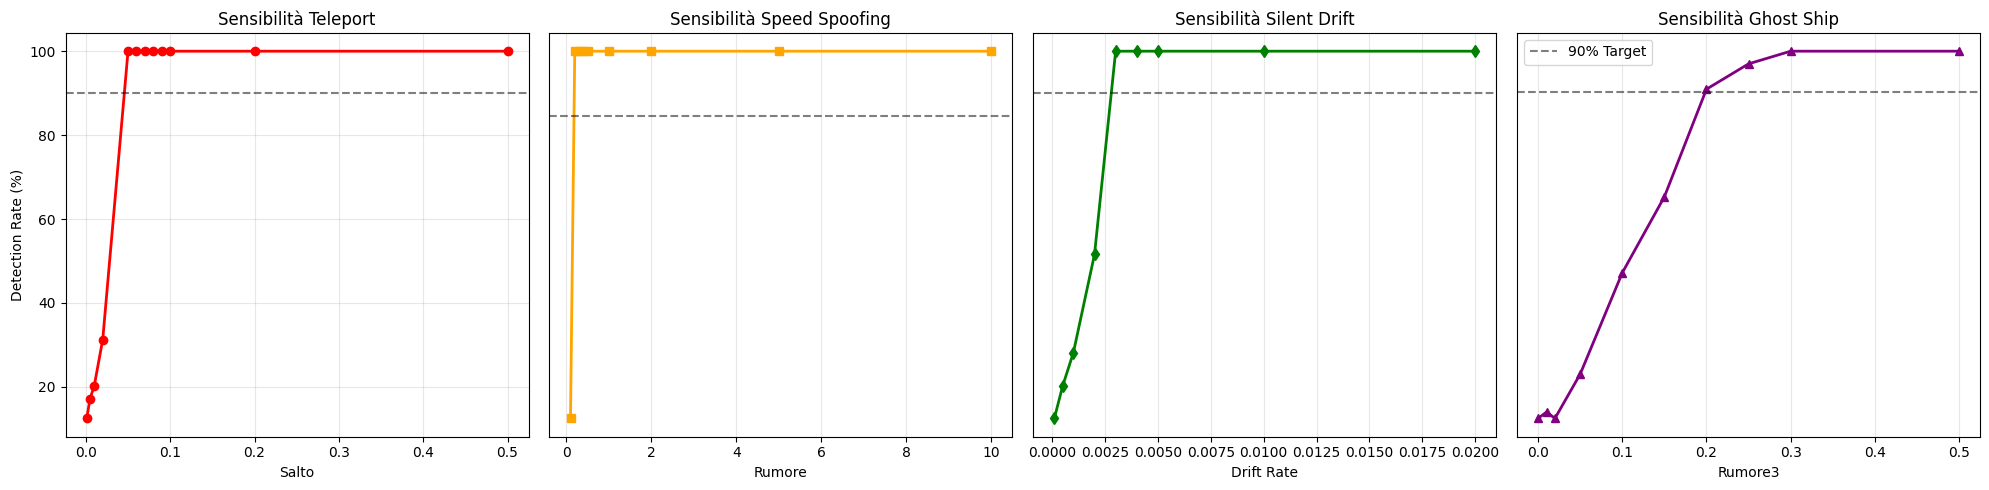

In [ ]:
# Configurazione Soglia Finale
FINAL_THRESHOLD = 0.023947

print(f"AVVIO STRESS TEST PARAMETRICO COMPLETO (Soglia: {FINAL_THRESHOLD})")

# Funzione Helper per calcolare il Detection Rate su un batch
def get_detection_rate(X_attacked, model, threshold):
    preds = model.predict(X_attacked, verbose=0, batch_size=512)
    mae = np.mean(np.abs(X_attacked - preds), axis=(1, 2))
    # Quanti superano la soglia?
    rate = np.sum(mae > threshold) / len(mae)
    return rate * 100.0

# Carichiamo un batch di dati puliti da usare come base
try:
    X_base, _ = next(test_gen)
    # Ne prendiamo 20000 per avere statistica solida
    X_base = X_base[:20000]
except:
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE)
    X_base, _ = next(test_gen)
    X_base = X_base[:20000]

print(f"Base dati: {len(X_base)} campioni puliti.")


# TEST 1: TELEPORT SENSITIVITY (Minimum Jump Distance)
print("\n1. Esecuzione Test Teleport (Salto Posizionale)")
jump_values = [0.001, 0.005, 0.01, 0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5]
teleport_rates = []

for j in jump_values:
    X_temp = X_base.copy()
    X_temp[:, -5:, 0] += j # Lat
    X_temp[:, -5:, 1] += j # Lon
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    teleport_rates.append(rate)
    print(f"   -> Salto {j:.4f}: Rilevato {rate:.1f}%")


# TEST 2: SPEED SPOOFING SENSITIVITY (Noise Intensity)
print("\n2. Esecuzione Test Speed Spoofing (Intensità Rumore)")
noise_std_values = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0, 10.0]
speed_rates = []

for n in noise_std_values:
    X_temp = X_base.copy()
    noise = np.random.normal(0, n, X_temp[:, :, 2].shape)
    X_temp[:, :, 2] += noise
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    speed_rates.append(rate)
    print(f"   -> Rumore {n:.1f}: Rilevato {rate:.1f}%")


# TEST 3: SILENT DRIFT SENSITIVITY (Drift Rate) 
print("\n3. Esecuzione Test Silent Drift (Lenta Deriva)")
drift_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02]
drift_rates = []
steps = np.arange(WINDOW_SIZE)

for d in drift_values:
    X_temp = X_base.copy()
    drift_vec = steps * d
    X_temp[:, :, 0] += drift_vec
    X_temp[:, :, 1] += drift_vec
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    drift_rates.append(rate)
    print(f"   -> Rateo {d:.4f}: Rilevato {rate:.1f}%")


# TEST 4: GHOST SHIP SENSITIVITY (Jitter Intensity)
# Qui variamo quanto è "rumorosa" l'inversione di rotta.
print("\n4. Esecuzione Test Ghost Ship (Intensità Jitter su COG)")
jitter_values = [0.0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]
ghost_rates = []

for j in jitter_values:
    X_temp = X_base.copy()
    # Inversione Rotta (180 gradi)
    X_temp[:, :, 3] = (X_temp[:, :, 3] + 0.5) % 1.0
    # Aggiunta Jitter Variabile
    jitter_noise = np.random.normal(0, j, X_temp[:, :, 3].shape)
    X_temp[:, :, 3] += jitter_noise
    
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    ghost_rates.append(rate)
    print(f"Jitter {j:.2f}: Rilevato {rate:.1f}%")


# Risultati Grafici
plt.figure(figsize=(20, 5))

# 1. Teleport
plt.subplot(1, 4, 1)
plt.plot(jump_values, teleport_rates, 'o-', color='red', linewidth=2)
plt.title("Sensibilità Teleport")
plt.xlabel("Salto")
plt.ylabel("Detection Rate (%)")
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# 2. Speed
plt.subplot(1, 4, 2)
plt.plot(noise_std_values, speed_rates, 's-', color='orange', linewidth=2)
plt.title("Sensibilità Speed Spoofing")
plt.xlabel("Rumore")
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# 3. Drift
plt.subplot(1, 4, 3)
plt.plot(drift_values, drift_rates, 'd-', color='green', linewidth=2)
plt.title("Sensibilità Silent Drift")
plt.xlabel("Drift Rate")
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# 4. Ghost Ship
plt.subplot(1, 4, 4)
plt.plot(jitter_values, ghost_rates, '^-', color='purple', linewidth=2)
plt.title("Sensibilità Ghost Ship")
plt.xlabel("Rumore3")
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5, label='90% Target')
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_4918/1222516853.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  detection_stats = df_res.groupby('Scenario').apply(lambda x: (x['Predicted'] == 1).sum() / len(x) * 100).reset_index(name='Detection_Rate')


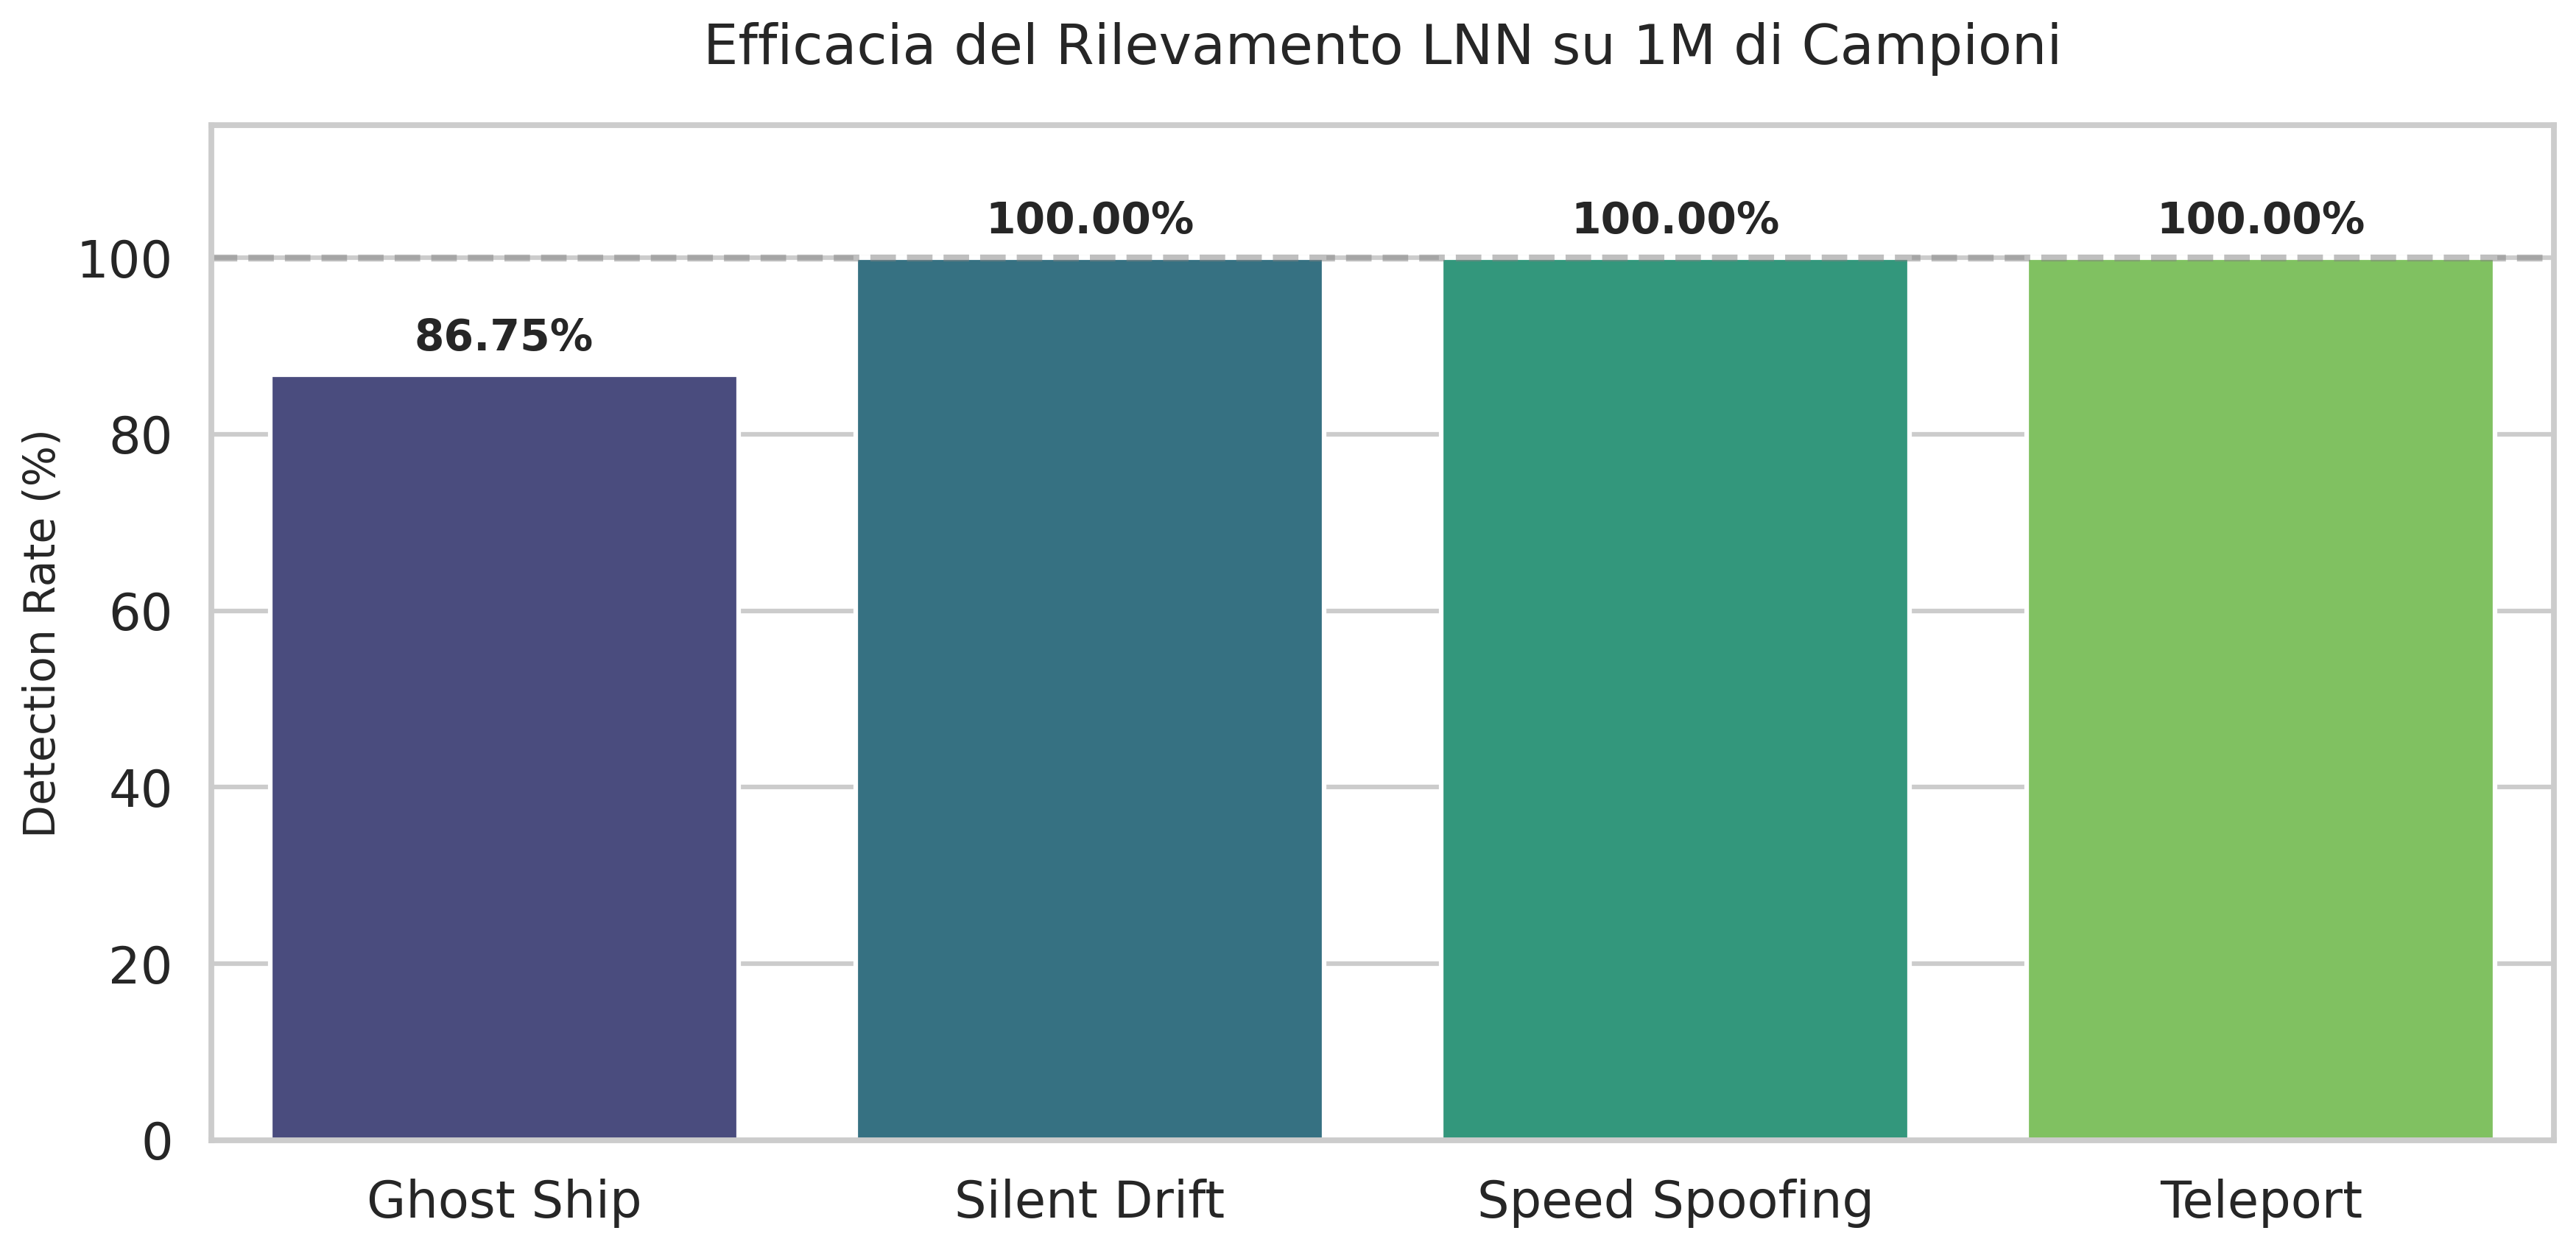

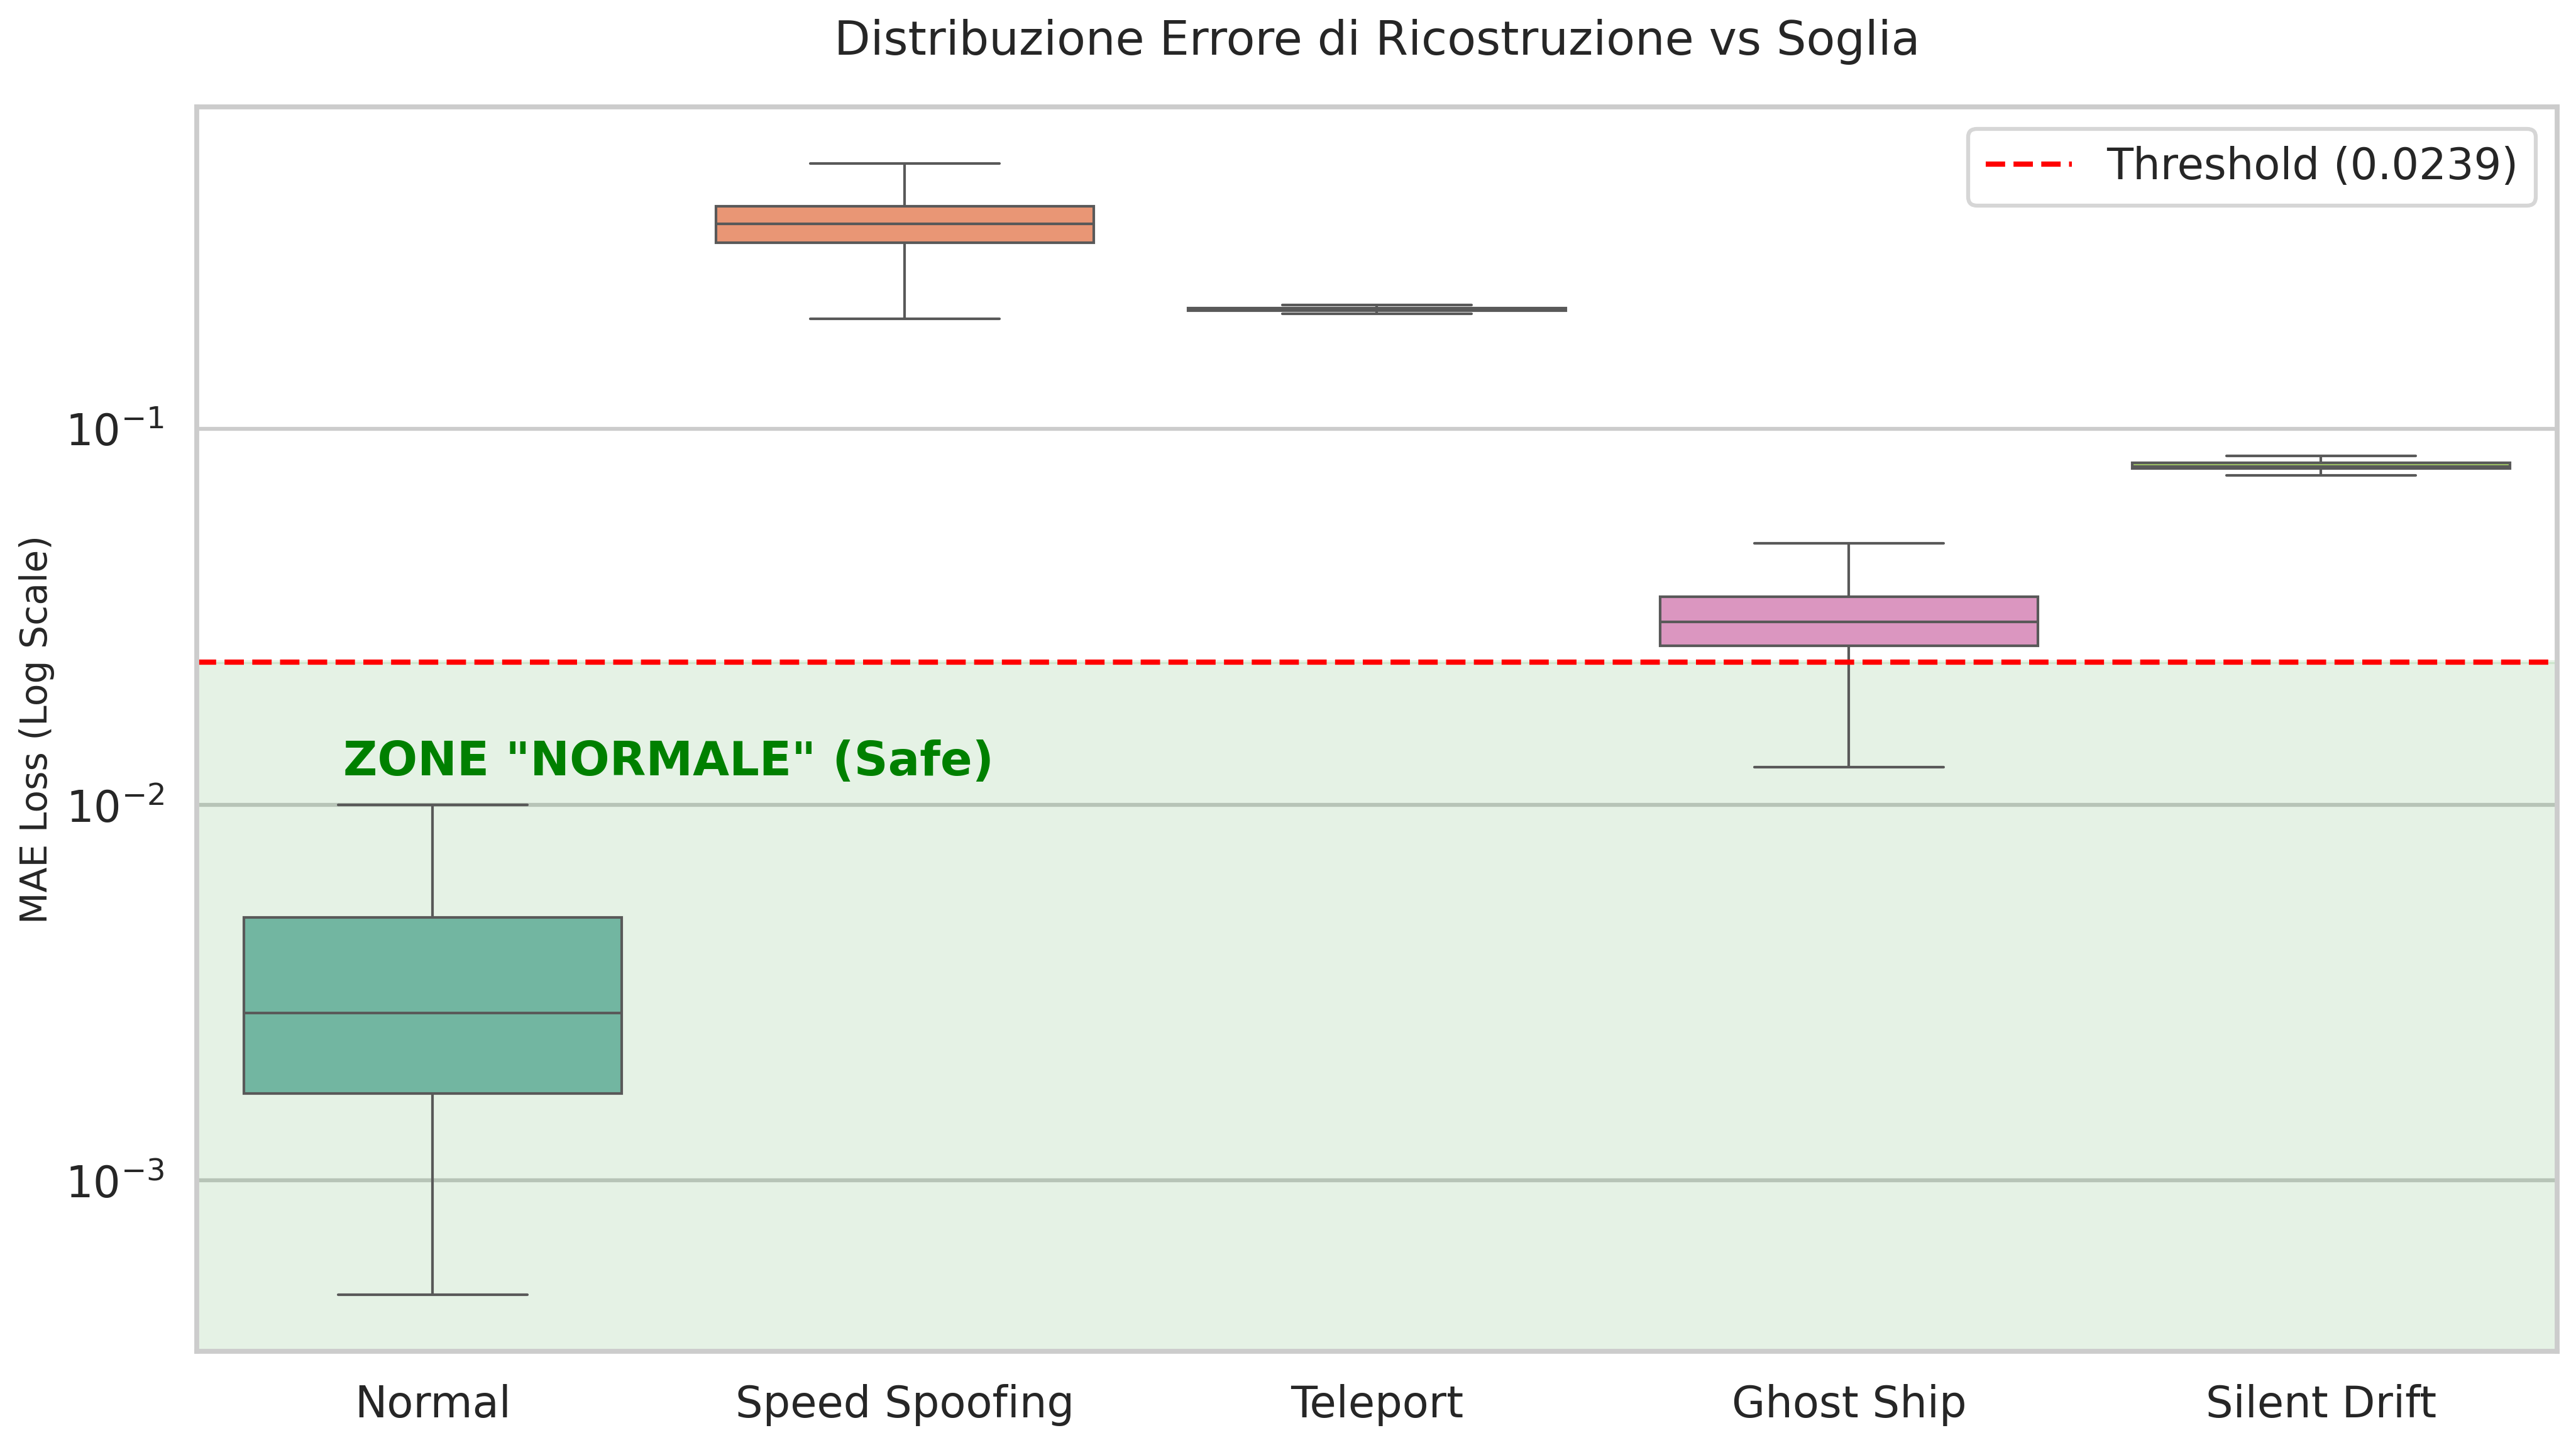

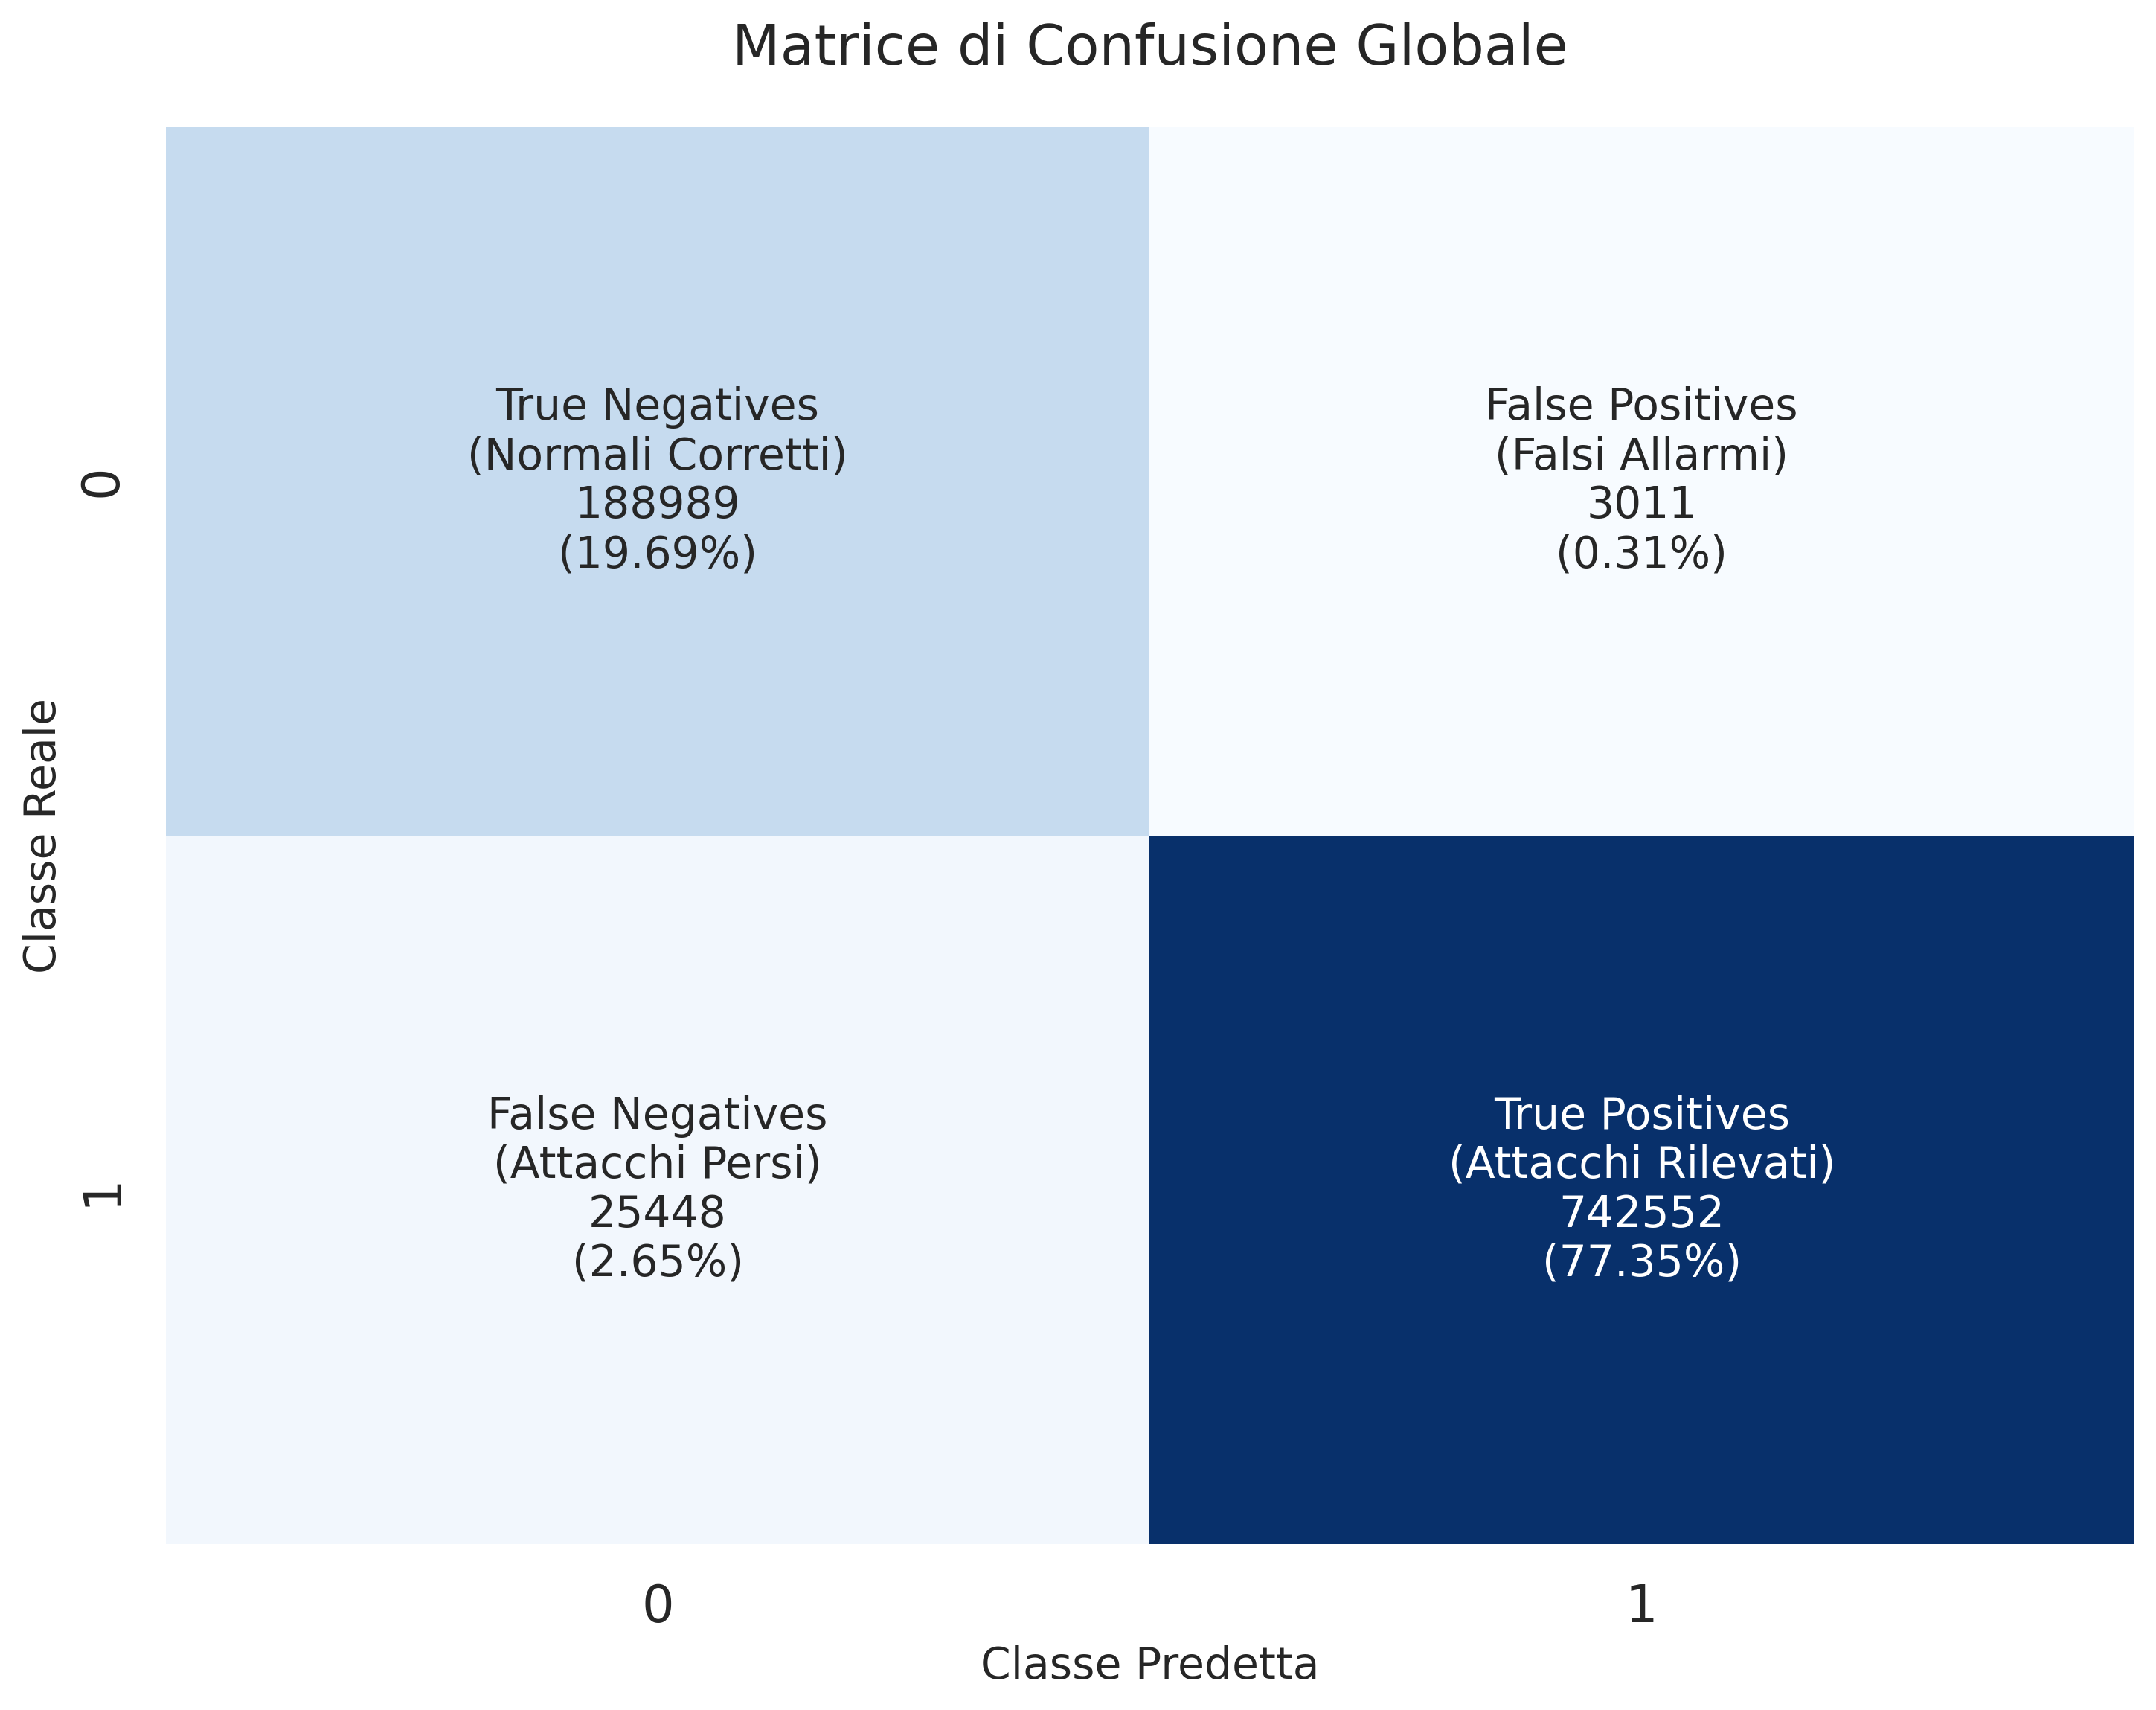


Tabella riassuntiva
| Scenario         |   Campioni Totali |   Rilevati come Attacco | Performance (%)      | Note                  |
|:-----------------|------------------:|------------------------:|:---------------------|:----------------------|
| Traffico Normale |            192000 |                    3011 | 98.43% (Specificità) | Falsi Positivi: 1.57% |
| Speed Spoofing   |            192000 |                  192000 | 100.00% (Recall)     | Rilevamento Critico   |
| Teleport         |            192000 |                  192000 | 100.00% (Recall)     | Rilevamento Critico   |
| Ghost Ship       |            192000 |                  166552 | 86.75% (Recall)      | Rilevamento Critico   |
| Silent Drift     |            192000 |                  192000 | 100.00% (Recall)     | Rilevamento Critico   |


In [ ]:
# Preparazione Dati per Visualizzazioni
# Mappiamo i codici numerici ai nomi leggibili
attack_map = {0: 'Normal', 1: 'Speed Spoofing', 2: 'Teleport', 3: 'Ghost Ship', 4: 'Silent Drift'}
df_res = pd.DataFrame({
    'MAE': mae_loss,
    'Predicted': y_pred,
    'Actual': y_true,
    'Attack_Type_Code': attack_types
})
df_res['Scenario'] = df_res['Attack_Type_Code'].map(attack_map)

sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Performance di Rilevamento
# Calcolo percentuali
detection_stats = df_res.groupby('Scenario').apply(lambda x: (x['Predicted'] == 1).sum() / len(x) * 100).reset_index(name='Detection_Rate')
# Rimuoviamo 'Normal' da questo grafico (che è Falsi Positivi) per focalizzarci sugli attacchi
attack_stats = detection_stats[detection_stats['Scenario'] != 'Normal'].copy()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Scenario', y='Detection_Rate', data=attack_stats, palette='viridis', hue='Scenario', legend=False)

# Annotazioni precise sopra le barre
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=14, fontweight='bold', xytext=(0, 5), textcoords='offset points')

plt.ylim(0, 115)
plt.title('Efficacia del Rilevamento LNN su 1M di Campioni', pad=20, fontsize=18)
plt.ylabel('Detection Rate (%)', fontsize=14)
plt.xlabel('')
plt.axhline(100, color='grey', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Analisi margini di sicurezza
# Per mostrare quanto è distante l'attacco dalla soglia
plt.figure(figsize=(14, 8))

ax = sns.boxplot(x='Scenario', y='MAE', data=df_res, palette='Set2', showfliers=False, hue='Scenario', legend=False)
plt.yscale('log') 

# Linea di Soglia
plt.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD:.4f})')

plt.title('Distribuzione Errore di Ricostruzione vs Soglia', fontsize=18, pad=20)
plt.ylabel('MAE Loss (Log Scale)', fontsize=14)
plt.xlabel('')
plt.legend(loc='upper right')

# Zona di Sicurezza
plt.axhspan(0, THRESHOLD, color='green', alpha=0.1)
plt.text(0.5, THRESHOLD/2, 'ZONE "NORMALE" (Safe)', color='green', fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

# Matrice di Confusione Globale
# Calcolo TP, TN, FP, FN globali
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Creiamo etichette personalizzate con i conteggi assoluti e percentuali
group_names = ['True Negatives\n(Normali Corretti)', 'False Positives\n(Falsi Allarmi)', 
               'False Negatives\n(Attacchi Persi)', 'True Positives\n(Attacchi Rilevati)']
group_counts = [f"{value:0.0f}" for value in [tn, fp, fn, tp]]
group_percentages = [f"{value:.2%}" for value in [tn/sum([tn,fp,fn,tp]), fp/sum([tn,fp,fn,tp]), fn/sum([tn,fp,fn,tp]), tp/sum([tn,fp,fn,tp])]]

labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10, 8))
sns.heatmap([[tn, fp], [fn, tp]], annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Matrice di Confusione Globale', fontsize=18, pad=20)
plt.ylabel('Classe Reale', fontsize=14)
plt.xlabel('Classe Predetta', fontsize=14)
plt.tight_layout()
plt.show()

# Tabella Riassuntiva
# Calcoliamo metriche dettagliate per ogni classe
summary_data = []

# Statistiche Normali
norm_mask = df_res['Scenario'] == 'Normal'
fp_count = (df_res[norm_mask]['Predicted'] == 1).sum()
tn_count = (df_res[norm_mask]['Predicted'] == 0).sum()
total_norm = len(df_res[norm_mask])
fpr = (fp_count / total_norm) * 100

summary_data.append({
    'Scenario': 'Traffico Normale',
    'Campioni Totali': total_norm,
    'Rilevati come Attacco': fp_count,
    'Performance (%)': f"{100-fpr:.2f}% (Specificità)",
    'Note': f"Falsi Positivi: {fpr:.2f}%"
})

# Statistiche Attacchi
for att in ['Speed Spoofing', 'Teleport', 'Ghost Ship', 'Silent Drift']:
    att_mask = df_res['Scenario'] == att
    tp_count = (df_res[att_mask]['Predicted'] == 1).sum()
    total_att = len(df_res[att_mask])
    recall = (tp_count / total_att) * 100
    
    summary_data.append({
        'Scenario': att,
        'Campioni Totali': total_att,
        'Rilevati come Attacco': tp_count,
        'Performance (%)': f"{recall:.2f}% (Recall)",
        'Note': "Rilevamento Critico"
    })

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("Tabella riassuntiva")
print("="*80)
print(df_summary.to_markdown(index=False))

In [ ]:
#Configurazione GPU per LNN
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Rilevata: {gpus[0]}")
    except RuntimeError as e:
        print(e)

# Parametri Generali
N_SAMPLES = 1000000 
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL'
SCALER_PATH = 'scaler.joblib'
WEIGHTS_PATH = 'lnn_autoencoder_best.weights.h5' 
WINDOW_SIZE = 30
RECURRENT_UNITS = 128
BOTTLENECK_SIZE = 64
GHOST_JITTER = 0.20 
FIXED_THRESH_CONSERVATIVE = 0.023947 

print("Tabella LNN - Definizione Soglie di Rilevamento")

# Caricamento Scaler e Modello
if not os.path.exists(SCALER_PATH) or not os.path.exists(WEIGHTS_PATH):
    raise FileNotFoundError("Scaler o Pesi non trovati. Controlla i percorsi.")

scaler = joblib.load(SCALER_PATH)
features = ['Latitude', 'Longitude', 'SOG', 'COG']
files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
# Costruzione Modello LNN
wiring = AutoNCP(RECURRENT_UNITS, output_size=BOTTLENECK_SIZE)
inputs = Input(shape=(WINDOW_SIZE, 4))

lnn_encoder = CfC(wiring, return_sequences=False, mixed_memory=True)(inputs)
repeat_vector = RepeatVector(WINDOW_SIZE)(lnn_encoder)
lnn_decoder = CfC(wiring, return_sequences=True, mixed_memory=True)(repeat_vector)
output = TimeDistributed(Dense(4))(lnn_decoder)

model = Model(inputs, output)
# Caricamento pesi
model.load_weights(WEIGHTS_PATH)
print("Pesi LNN caricati con successo.")

def make_windows(df, w=30):
    vals = df[features].values
    return np.array([vals[i:i+w] for i in range(len(vals)-w+1)])

#Mae
mae_normal = []
mae_ghost = []
collected = 0

print(f"Elaborazione progressiva fino a {N_SAMPLES} campioni...")

for f in files:
    if collected >= N_SAMPLES: break
    try:
        df = pd.read_parquet(f, columns=features + ['TrajectoryID'])
        df[features] = scaler.transform(df[features])
        
        for _, group in df.groupby('TrajectoryID'):
            if len(group) < 30: continue
            
            X = make_windows(group)
            if len(X) == 0: continue
            
            p_norm = model.predict(X, verbose=0, batch_size=256)
            loss_norm = np.mean(np.abs(X - p_norm), axis=(1,2))
            mae_normal.extend(loss_norm)
            
            X_g = X.copy()
            X_g[:, :, 3] = (X_g[:, :, 3] + 0.5) % 1.0 
            X_g[:, :, 3] += np.random.normal(0, GHOST_JITTER, X_g[:, :, 3].shape)
            
            p_ghost = model.predict(X_g, verbose=0, batch_size=256)
            loss_ghost = np.mean(np.abs(X_g - p_ghost), axis=(1,2))
            mae_ghost.extend(loss_ghost)
            
            collected += len(X)
            if collected >= N_SAMPLES: break
            
        print(f"Status: {collected}/{N_SAMPLES} campioni elaborati...", end='\r')
            
    except Exception as e:
        print(f"Skip file {f}: {e}")
        continue

print(f"\nAnalisi completata su {len(mae_normal)} campioni.")

mae_normal = np.array(mae_normal)
mae_ghost = np.array(mae_ghost)

#Configurazione soglie
thresh_agg = np.percentile(mae_ghost, 0.5)
thresh_con = FIXED_THRESH_CONSERVATIVE

# Calcolo metriche 
def get_stats(t):
    dr = np.mean(mae_ghost > t) * 100 
    fpr = np.mean(mae_normal > t) * 100 
    return dr, fpr

dr_agg, fpr_agg = get_stats(thresh_agg)
dr_con, fpr_con = get_stats(thresh_con)

# Tabella
data = [
    [
        "Aggressivo (Zero Trust)", 
        f"{thresh_agg:.5f}", 
        f"{dr_agg:.2f}%", 
        f"~{fpr_agg:.2f}%"
    ],
    [
        "Conservativo (Baseline LNN)", 
        f"{thresh_con:.5f}", 
        f"{dr_con:.2f}%", 
        f"~{fpr_con:.2f}%"
    ]
]

df_final = pd.DataFrame(data, columns=["Profilo Operativo", "Soglia (τ)", "Detection Rate (Ghost Ship)", "Falsi Positivi (FPR)"])

print("\n" + "="*80)
print("ANALISI OPERATIVA FINALE (LNN - Liquid Neural Network)")
print("="*80)
try:
    print(df_final.to_markdown(index=False))
except:
    print(df_final.to_string(index=False))
print("="*80)

GPU Rilevata: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
--- GENERAZIONE TABELLA LNN: AGGRESSIVE vs CONSERVATIVE (500k Samples) ---
Ricostruzione Architettura LNN (Float32 Mode)...
Pesi LNN caricati con successo.
Elaborazione progressiva fino a 1000000 campioni...
Status: 1000054/1000000 campioni elaborati...
Analisi completata su 1000054 campioni.

ANALISI OPERATIVA FINALE (LNN - Liquid Neural Network)
| Profilo Operativo           |   Soglia (τ) | Detection Rate (Ghost Ship)   | Falsi Positivi (FPR)   | Interpretazione                                                           |
|:----------------------------|-------------:|:------------------------------|:-----------------------|:--------------------------------------------------------------------------|
| Aggressivo (Zero Trust)     |      0.01694 | 99.50%                        | ~4.18%                 | Massima sicurezza (Target: >99.5% Detection). Accetta alti falsi allarmi. |
| Conservativo (Baseline LNN) |